# Balanced DGP

Create balanced treatment assignment.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression

## Base Data

Treated percentage: 44.70%


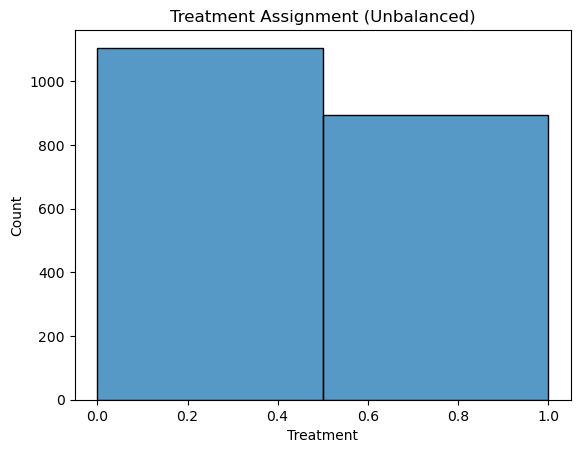

In [2]:
np.random.seed(42)

n = 1000

# Step 1: Generate three covariates
X1 = np.random.normal(0, 1, 2*n)  # Covariate 1: Normally distributed
X2 = np.random.uniform(0, 1, 2*n)  # Covariate 2: Uniformly distributed
X3 = np.random.binomial(1, 0.3, 2*n)  # Covariate 3: Binary (Bernoulli trial)

# Step 2: Define the treatment assignment probabilities (propensity scores)
# Use a logistic model with skewed coefficients to introduce imbalance
logits = 2 * X1 - 1 * X2 + 0.5 * X3
ps = 1 / (1 + np.exp(-logits))  # Logistic function

# Step 3: Assign treatment based on the propensity scores
D = np.random.binomial(1, ps)  # 1 if treated, 0 otherwise

# Step 4: Generate an outcome variable (optional)
# Define outcome as a function of covariates and treatment
Y = 3 + 1.5 * X1 - 2 * X2 + X3 + 2 * D + np.random.normal(0, 0.5, 2*n)

# Combine into a DataFrame
data = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'D': D,
    'Y': Y,
    'm_oracle': ps,
})

print(f"Treated percentage: {data['D'].mean() * 100:.2f}%")

# Step 5: Visualize treatment imbalance
sns.histplot(data['D'], bins=2, kde=False)
plt.title("Treatment Assignment (Unbalanced)")
plt.xlabel("Treatment")
plt.ylabel("Count")
plt.show()

## Estimated propensity score

In [3]:
covariates = ['X1', 'X2', 'X3']

df_train, df_test = train_test_split(data, test_size=0.5, random_state=42)

# Step 6: Fit a Random Forest to estimate the propensity scores
model = RandomForestClassifier(n_estimators=100, random_state=42)
model = LogisticRegression(random_state=42)
model.fit(df_train[covariates], df_train['D'])

for df in [df_train, df_test]:
    df['m_hat'] = model.predict_proba(df[covariates])[:, 1]

    calibrator = IsotonicRegression(out_of_bounds='clip', y_min=0, y_max=1)
    df['m_calibrated'] = calibrator.fit_transform(df['m_hat'], df['D'])

df_train.head()

,X1,X2,X3,D,Y,m_oracle,m_hat,m_calibrated
440,0.384065,0.718454,1,1,6.088134,0.634061,0.679512,0.762376
573,-0.219101,0.247560,1,0,3.736979,0.453693,0.407073,0.428571
946,-1.525525,0.659045,0,0,-0.439215,0.023890,0.016803,0.010526
997,0.640843,0.154925,0,1,5.657675,0.755241,0.705572,0.762376
503,0.562969,0.483040,1,1,6.209506,0.758211,0.775320,0.772727


## Define weights

In [4]:
clipping_threshold = 1e-12

for df in [df_train, df_test]:
    for ps in ['m_oracle', 'm_hat', 'm_calibrated']:
        ps_clipped = df[ps].clip(clipping_threshold, 1.0 - clipping_threshold)

        df[f'{ps}_ate_weights'] = df['D'] / ps_clipped + (1 - df['D']) / (1 - ps_clipped)

        df[f'{ps}_att_weights'] = df['D'] + (1 - df['D']) * ps_clipped / (1 - ps_clipped)

## Save Data

In [5]:
df_train.head()

,X1,X2,X3,D,Y,m_oracle,m_hat,m_calibrated,m_oracle_ate_weights,m_oracle_att_weights,m_hat_ate_weights,m_hat_att_weights,m_calibrated_ate_weights,m_calibrated_att_weights
440,0.384065,0.718454,1,1,6.088134,0.634061,0.679512,0.762376,1.577136,1.000000,1.471645,1.00000,1.311688,1.000000
573,-0.219101,0.247560,1,0,3.736979,0.453693,0.407073,0.428571,1.830472,0.830472,1.686550,0.68655,1.750000,0.750000
946,-1.525525,0.659045,0,0,-0.439215,0.023890,0.016803,0.010526,1.024475,0.024475,1.017090,0.01709,1.010638,0.010638
997,0.640843,0.154925,0,1,5.657675,0.755241,0.705572,0.762376,1.324081,1.000000,1.417290,1.00000,1.311688,1.000000
503,0.562969,0.483040,1,1,6.209506,0.758211,0.775320,0.772727,1.318893,1.000000,1.289790,1.00000,1.294118,1.000000


In [6]:
dgp_name = "balanced"

df_train.to_csv(f'data/{dgp_name}_train.csv', index=False)
df_test.to_csv(f'data/{dgp_name}_test.csv', index=False)